### To install
`pip3 install git+https://github.com/gtcanalytics/randl_client`

In [1]:
import randl_client

### Create an instance of the driver class

In [2]:
randl = randl_client.Randl()

In [3]:
randl

URL:http://seismic-ai.com:8011/randl/

-Bulletin-
Start:		2024-05-01T00:00:00
End:		2024-05-11T00:00:00
Stations:	100
Events:		1
Drop fraction:	0.2
Seed:	555

-Window-
Start:			2024-05-10 18:43:15.431390
Length:			1800
Min_phases:		5
Exclude associated:	False

-DML-
Models:		['pwave']
Sampling:	['full']
Num_samples:	10
Arids:		['None']
Pwave_model:	None
Baz_model:	None
Exclude stations:	True

-Beamsearch-
Beam width:	5
Max dist:	5000
Max time:	500
Sequence dist:	500
Sequence time:	500

### Randl Setter Functions
#### Bulletin Generator

`randl.set_bulletin_start('timestamp')`

`randl.set_bulletin_end('timestamp')`

`randl.set_bulletin_n_stations(int)`

`randl.set_bulletin_n_events(int)`

`randl.set_bulletin_drop_fraction(float)`

`randl.set_bulletin_seed(int)`

`bulletin = randl.create_bulletin()`

#### Windowing

`randl.set_window_start('timestamp')`

`randl.set_window_length(int)`

`randl.set_window_phases_required(int)`

`randl.set_window_exclude_associated_phases(Boolean)`

`window = randl.window_catalog(bulletin_dataframe)`

#### DML Predictions

`randl.set_dml_models(list).` Example: ['pwave', 'baz']

`randl.set_dml_sampling(list).` Example: ['kfn', 'knn', 'full', 'random']

`randl.set_dml_num_samples(int)`

`randl.set_dml_exclude_duplicate_stations(Boolean)`

`randl.set_dml_pwave_model("mlflow_model_path")`

`dml_predictions = randl.dml_prediction(window_dataframe)`

#### Beamsearch

`randl.set_beamwidth(int)`

`randl.set_beam_maxdist(int)`

`randl.set_beam_maxtime(int)`

`randl.set_beam_sequencedist(int)`

`randl.set_beam_sequencetimedist(int)`

`randl.beamsearch(window_dataframe, dml_predictions_dataframe)`

### Example Run

In [4]:
randl.set_bulletin_start('2024-05-01T00:00:00')
randl.set_bulletin_end('2024-05-01T0:30:00')
randl.set_bulletin_n_stations(50)
randl.set_bulletin_n_events(1)
randl.set_bulletin_drop_fraction(0.2)
randl.set_bulletin_seed(555)
bulletin = randl.create_bulletin()

randl.set_window_start(bulletin.loc[0,"TIME_ARRIV"])
randl.set_window_length(1800)
randl.set_window_phases_required(5)
randl.set_window_exclude_associated_phases(False)
window = randl.window_catalog(bulletin)

randl.set_dml_models(['pwave'])
randl.set_dml_sampling(['kfn'])
randl.set_dml_num_samples(30)
randl.set_dml_exclude_duplicate_stations(True)
dml_predictions = randl.dml_prediction(window)

randl.set_beamwidth(5)
randl.set_beam_maxdist(1000)
randl.set_beam_maxtime(100)
randl.set_beam_sequencedist(300)
randl.set_beam_sequencetimedist(100)
centroid, mean_time, mean_score = randl.beamsearch(window, dml_predictions)

Success
Success
Success
Success


### Plotting result

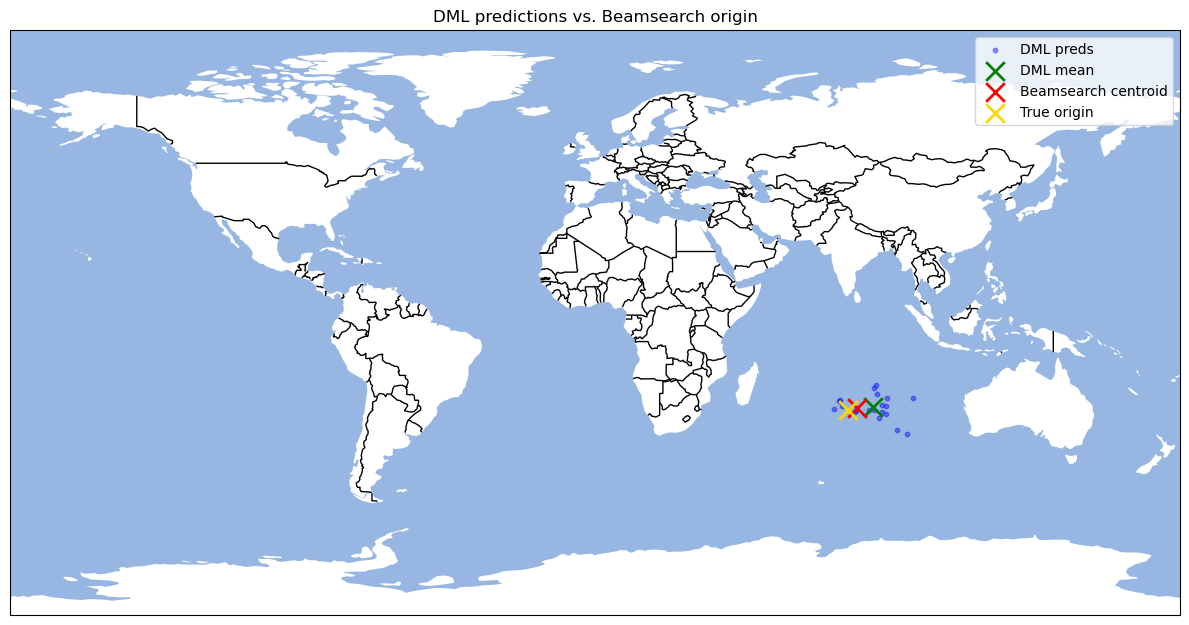

origin lat:     -26.8536157114
dml_mean  lat:  -26.002263494765
beamsearch lat: -26.231914306776474
origin lon:     77.8163761165
dml_mean  lon:  85.44893443111
beamsearch lon: 80.7200522629018


In [5]:
import matplotlib.pyplot as plt
from statistics import mean
import cartopy

origin_time = bulletin.loc[0,"ORIG_TIME"]
origin_lon = bulletin.loc[0,"ORIG_LON"]
origin_lat = bulletin.loc[0,"ORIG_LAT"]
dml_lat_mean = mean(dml_predictions.LAT_ORIG)
dml_lon_mean = mean(dml_predictions.LON_ORIG)
beamsearch_lon = float(centroid.split(',')[0][1:-1])


if centroid.split(',')[1] == '-':
    beamsearch_lat = float(centroid.split(',')[1][1:-1])
else:
    beamsearch_lat = float(centroid.split(',')[1][:-1])

plt.rcParams['figure.figsize'] = [12,12]
geo_axes = plt.axes(projection=cartopy.crs.PlateCarree())
geo_axes.add_feature(cartopy.feature.BORDERS)
geo_axes.add_feature(cartopy.feature.OCEAN)
geo_axes.scatter(dml_predictions['LON_ORIG'], dml_predictions['LAT_ORIG'], marker='.', s=40, linewidth=1, c='b', alpha=0.4, label="DML preds")
geo_axes.scatter(dml_lon_mean, dml_lat_mean, marker='x', linewidth=2, c='g', s=180, alpha=1, label="DML mean")
geo_axes.scatter(beamsearch_lon, beamsearch_lat, marker='x', linewidth=2, c='r', s=180, alpha=1, label="Beamsearch centroid")
geo_axes.scatter(origin_lon, origin_lat, marker='x', linewidth=2, c='gold', s=180, alpha=1, label="True origin")
geo_axes.set_global()

plt.title("DML predictions vs. Beamsearch origin")
plt.legend()
plt.tight_layout()
plt.show()

print("origin lat:    ", origin_lat)
print("dml_mean  lat: ", dml_lat_mean)
print("beamsearch lat:", beamsearch_lat)

print("origin lon:    ", origin_lon)
print("dml_mean  lon: ", dml_lon_mean)
print("beamsearch lon:", beamsearch_lon)

# Full bulletin associations

### Sample of iterating over entire bulletin using sliding window

In [6]:
randl.set_bulletin_start('2024-05-01T00:00:00')
randl.set_bulletin_end('2024-05-01T2:00:00')
randl.set_bulletin_n_stations(50)
randl.set_bulletin_n_events(3)
randl.set_bulletin_drop_fraction(0.2)
randl.set_bulletin_seed(123)
bulletin = randl.create_bulletin()

Success


In [7]:
from dateutil import parser
from datetime import timedelta
import pandas as pd
origins = pd.DataFrame(columns=['Window_start', 'Window_end', 'DML_mean_lat', 'DML_mean_lon', 'Beamsearch_lat', 
                                'Beamsearch_lon', 'Beamsearch_time'])
window_length = 1800
randl.set_window_length(window_length)
randl.set_window_phases_required(5)
randl.set_window_exclude_associated_phases(False)

starttime = parser.parse(randl.bulletin_start)
bulletin_end = parser.parse(bulletin.TIME_ARRIV[len(bulletin)-1])

while starttime < bulletin_end:
    print("Starting window at", starttime.strftime('%Y-%m-%dT%H:%M:%S'))
    randl.set_window_start(starttime.strftime('%Y-%m-%dT%H:%M:%S'))
    window = randl.window_catalog(bulletin)
    
    try:
        print("Arrivals in window:", len(window))
        if len(window) > 0:

            window_end = parser.parse(window.TIME_ARRIV.iloc[len(window)-1])
            window_start = parser.parse(window.TIME_ARRIV.iloc[0])
            
            print("window_start", window_start)
            print("window_end", window_end)

            dml_predictions = randl.dml_prediction(window)

            centroid, mean_time, mean_score = randl.beamsearch(window, dml_predictions)

            dml_lat_mean = mean(dml_predictions.LAT_ORIG)
            dml_lon_mean = mean(dml_predictions.LON_ORIG)

            beamsearch_lon = float(centroid.split(',')[0][1:-1])


            if centroid.split(',')[1] == '-':
                beamsearch_lat = float(centroid.split(',')[1][1:-1])
            else:
                beamsearch_lat = float(centroid.split(',')[1][:-1])
            beamsearch_time = parser.parse(mean_time)

            result=pd.DataFrame()
            result['Window_start'] = [window_start]
            result['Window_end'] = [window_end]
            result['DML_mean_lat'] = [dml_lat_mean]
            result['DML_mean_lon'] = [dml_lon_mean]
            result['Beamsearch_lat'] = [beamsearch_lat]
            result['Beamsearch_lon'] = [beamsearch_lon]
            result['Beamsearch_time'] = [beamsearch_time]
            origins = pd.concat([origins, result], ignore_index=True)

            starttime += timedelta(seconds=window_length)

        else:
            starttime += timedelta(seconds=window_length)
            print("No arrivals. Moving window to start at", starttime.strftime('%Y-%m-%dT%H:%M:%S'))
    except Exception as e:
        starttime += timedelta(seconds=window_length)
        print(e)
        continue
        

Starting window at 2024-05-01T00:00:00
Success
Arrivals in window: 20
window_start 2024-05-01 00:19:21.955876
window_end 2024-05-01 00:24:31.128185
Success
Success
Starting window at 2024-05-01T00:30:00
Success
Arrivals in window: 0
No arrivals. Moving window to start at 2024-05-01T01:00:00
Starting window at 2024-05-01T01:00:00
Success
Arrivals in window: 42
window_start 2024-05-01 01:06:12.079697
window_end 2024-05-01 01:32:23.882610
Success
Success
Starting window at 2024-05-01T01:30:00
Success
Arrivals in window: 11
window_start 2024-05-01 01:30:20.037253
window_end 2024-05-01 01:32:23.882610
Success
Success


### Origins found:

In [8]:
origins

,Window_start,Window_end,DML_mean_lat,DML_mean_lon,Beamsearch_lat,Beamsearch_lon,Beamsearch_time
0,2024-05-01 00:19:21.955876,2024-05-01 00:24:31.128185,28.844647,128.191658,28.081319,127.586786,2024-05-01 00:13:04.519129
1,2024-05-01 01:06:12.079697,2024-05-01 01:32:23.882610,-53.227283,83.358143,-58.60452,119.926884,2024-05-01 01:03:50.979364
2,2024-05-01 01:30:20.037253,2024-05-01 01:32:23.882610,-31.174563,18.073548,-32.36486,18.087603,2024-05-01 01:20:41.096689


### True origins in bulletin

In [9]:
bulletin.ORIG_TIME.unique()

array(['2024-05-01 00:12:42.541092', '2024-05-01 01:01:34.522710',
       '2024-05-01 01:19:59.696761'], dtype=object)

### Plotting true origins vs found origins

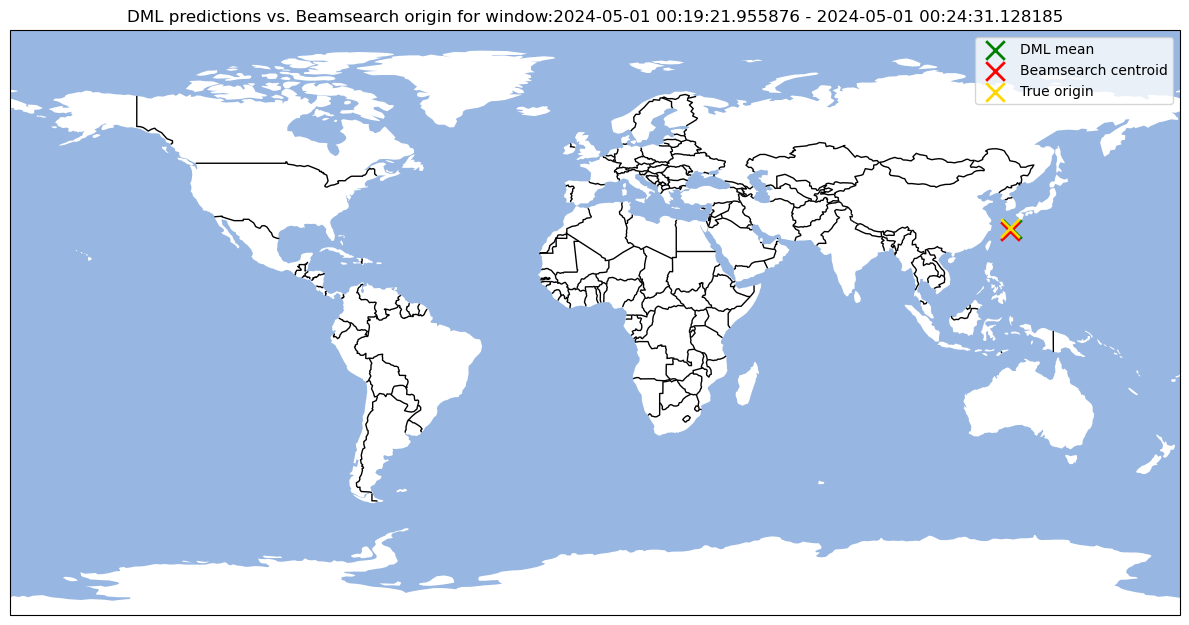

True origin time: 2024-05-01 00:12:42.541092
Beam origin time: 127.5867858609917
origin lat:     29.0815805999
dml_mean  lat:  28.844647248175
beamsearch lat: 28.081318808525335
origin lon:     127.6028955088
dml_mean  lon:  128.19165821553125
beamsearch lon: 127.5867858609917


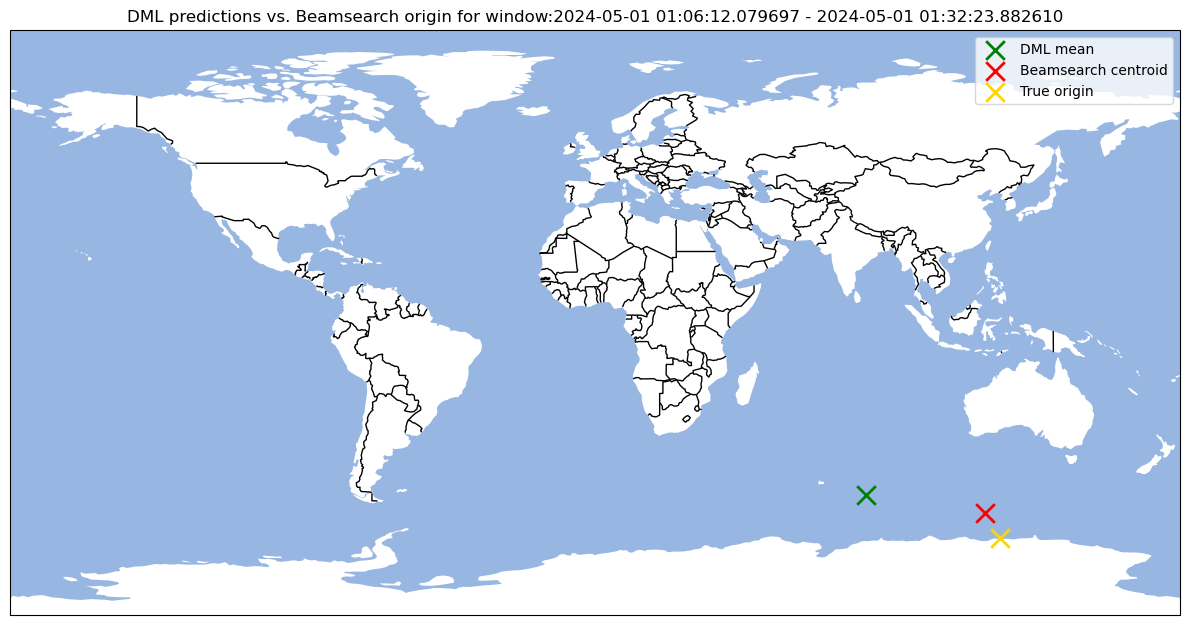

True origin time: 2024-05-01 01:01:34.522710
Beam origin time: 119.9268838618792
origin lat:     -66.4389088805
dml_mean  lat:  -53.227283212821426
beamsearch lat: -58.60452006540172
origin lon:     124.7422410975
dml_mean  lon:  83.35814262499285
beamsearch lon: 119.9268838618792


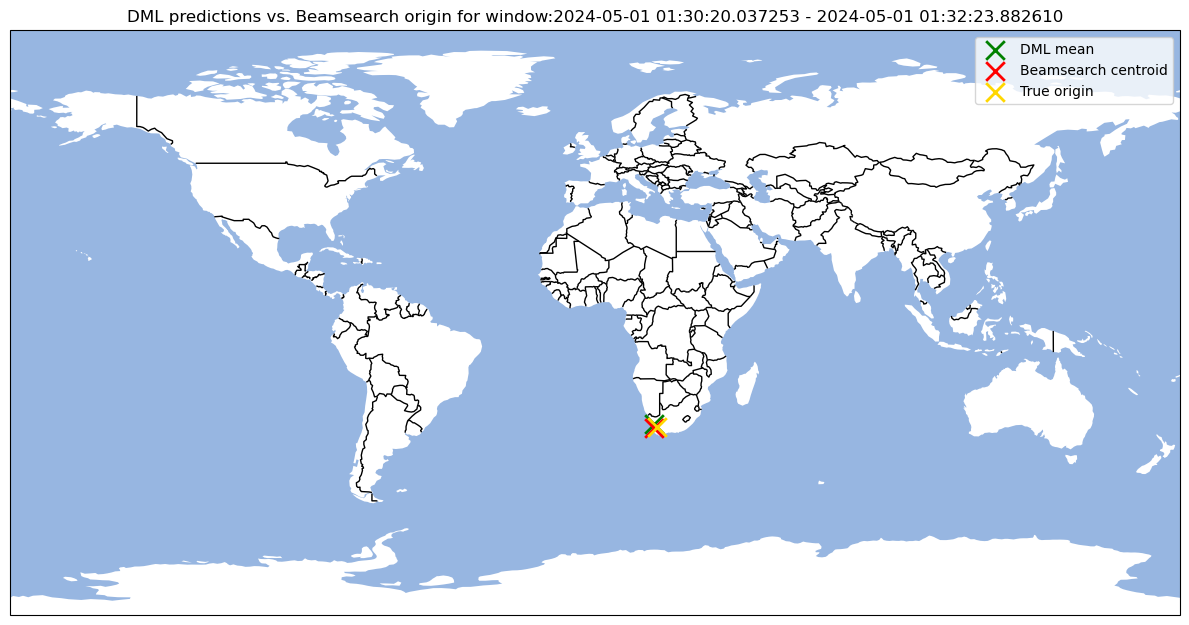

True origin time: 2024-05-01 01:19:59.696761
Beam origin time: 18.08760324173814
origin lat:     -32.0434908357
dml_mean  lat:  -31.174562952057144
beamsearch lat: -32.36486042869398
origin lon:     19.1726441268
dml_mean  lon:  18.07354798467143
beamsearch lon: 18.08760324173814
origin lat:     -32.0434908357
dml_mean  lat:  -31.174562952057144
beamsearch lat: -32.36486042869398
origin lon:     19.1726441268
dml_mean  lon:  18.07354798467143
beamsearch lon: 18.08760324173814


In [10]:
import matplotlib.pyplot as plt
from statistics import mean
import cartopy

plt.rcParams['figure.figsize'] = [12,12]

try:
    for i in range(len(bulletin.ORIG_TIME.unique())):

        origin_time = bulletin.ORIG_TIME.unique()[i]
        origin_lon = bulletin.ORIG_LON.unique()[i]
        origin_lat = bulletin.ORIG_LAT.unique()[i]

        dml_lat_mean = origins.DML_mean_lat.iloc[i]
        dml_lon_mean = origins.DML_mean_lon.iloc[i]
        beamsearch_lat = origins.Beamsearch_lat.iloc[i]    
        beamsearch_lon = origins.Beamsearch_lon.iloc[i]
        beamsearch_time = origins.Beamsearch_lon.iloc[i]

        geo_axes = plt.axes(projection=cartopy.crs.PlateCarree())
        geo_axes.add_feature(cartopy.feature.BORDERS)
        geo_axes.add_feature(cartopy.feature.OCEAN)
        geo_axes.scatter(dml_lon_mean, dml_lat_mean, marker='x', linewidth=2, c='g', s=180, alpha=1, label="DML mean")
        geo_axes.scatter(beamsearch_lon, beamsearch_lat, marker='x', linewidth=2, c='r', s=180, alpha=1, label="Beamsearch centroid")
        geo_axes.scatter(origin_lon, origin_lat, marker='x', linewidth=2, c='gold', s=180, alpha=1, label="True origin")
        geo_axes.set_global()
        
        plt.title("DML predictions vs. Beamsearch origin for window:" + str(origins.Window_start.iloc[i]) + " - " + str(origins.Window_end.iloc[i]))
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print("True origin time:", origin_time)
        print("Beam origin time:", beamsearch_time)
        
        print("origin lat:    ", origin_lat)
        print("dml_mean  lat: ", dml_lat_mean)
        print("beamsearch lat:", beamsearch_lat)

        print("origin lon:    ", origin_lon)
        print("dml_mean  lon: ", dml_lon_mean)
        print("beamsearch lon:", beamsearch_lon)  
        
except Exception as e:
    print(e)

print("origin lat:    ", origin_lat)
print("dml_mean  lat: ", dml_lat_mean)
print("beamsearch lat:", beamsearch_lat)

print("origin lon:    ", origin_lon)
print("dml_mean  lon: ", dml_lon_mean)
print("beamsearch lon:", beamsearch_lon)

### Sample iterating over an entire bulletin based on arrivals

In [12]:
from dateutil import parser
from datetime import timedelta
import pandas as pd
origins = pd.DataFrame(columns=['Window_start', 'Window_end', 'DML_mean_lat', 'DML_mean_lon', 'Beamsearch_lat', 
                                'Beamsearch_lon', 'Beamsearch_time'])
window_length = 1200 # max travel time from initial arrival found
randl.set_window_length(window_length)
randl.set_window_phases_required(5)
randl.set_window_exclude_associated_phases(False)

bulletin_arrivals = pd.to_datetime(bulletin.TIME_ARRIV)

starttime  = bulletin_arrivals.iloc[0]
bulletin_end = bulletin_arrivals[len(bulletin_arrivals)-1]

while starttime < bulletin_end:
    if starttime != bulletin_arrivals.iloc[0]:
        next_arrival_idx = bulletin_arrivals.index[bulletin_arrivals >= starttime].tolist()[0]
        starttime = bulletin_arrivals[next_arrival_idx]
    
    print("Starting window at", starttime.strftime('%Y-%m-%dT%H:%M:%S'))
    randl.set_window_start(starttime.strftime('%Y-%m-%dT%H:%M:%S'))
    window = randl.window_catalog(bulletin)
    
    try:
        print("Arrivals in window:", len(window))
        if len(window) > 0:

            window_end = parser.parse(window.TIME_ARRIV.iloc[len(window)-1])
            window_start = parser.parse(window.TIME_ARRIV.iloc[0])
            
            print("window_start", window_start)
            print("window_end", window_end)

            dml_predictions = randl.dml_prediction(window)

            centroid, mean_time, mean_score = randl.beamsearch(window, dml_predictions)

            dml_lat_mean = mean(dml_predictions.LAT_ORIG)
            dml_lon_mean = mean(dml_predictions.LON_ORIG)

            beamsearch_lon = float(centroid.split(',')[0][1:-1])

            if centroid.split(',')[1] == '-':
                beamsearch_lat = float(centroid.split(',')[1][1:-1])
            else:
                beamsearch_lat = float(centroid.split(',')[1][:-1])
            beamsearch_time = parser.parse(mean_time)

            result=pd.DataFrame()
            result['Window_start'] = [window_start]
            result['Window_end'] = [window_end]
            result['DML_mean_lat'] = [dml_lat_mean]
            result['DML_mean_lon'] = [dml_lon_mean]
            result['Beamsearch_lat'] = [beamsearch_lat]
            result['Beamsearch_lon'] = [beamsearch_lon]
            result['Beamsearch_time'] = [beamsearch_time]
            origins = pd.concat([origins, result], ignore_index=True)

            starttime += timedelta(seconds=window_length)

        else:
            starttime += timedelta(seconds=window_length)
            print("No arrivals. Moving window to start at", starttime.strftime('%Y-%m-%dT%H:%M:%S'))
    except Exception as e:
        starttime += timedelta(seconds=window_length)
        print(e)
        continue
        

Starting window at 2024-05-01T00:19:21
Success
Arrivals in window: 20
window_start 2024-05-01 00:19:21.955876
window_end 2024-05-01 00:24:31.128185
Success
Success
Starting window at 2024-05-01T01:06:12
Success
Arrivals in window: 20
window_start 2024-05-01 01:06:12.079697
window_end 2024-05-01 01:24:35.787446
Success
Success
Starting window at 2024-05-01T01:26:24
Success
Arrivals in window: 21
window_start 2024-05-01 01:26:24.990231
window_end 2024-05-01 01:32:23.882610
Success
Success


In [13]:
origins

,Window_start,Window_end,DML_mean_lat,DML_mean_lon,Beamsearch_lat,Beamsearch_lon,Beamsearch_time
0,2024-05-01 00:19:21.955876,2024-05-01 00:24:31.128185,28.844647,128.191658,28.081319,127.586786,2024-05-01 00:13:04.519129
1,2024-05-01 01:06:12.079697,2024-05-01 01:24:35.787446,-66.345978,125.620619,-65.336281,125.811782,2024-05-01 01:02:14.736128
2,2024-05-01 01:26:24.990231,2024-05-01 01:32:23.882610,-30.817403,18.97706,-29.541218,20.003674,2024-05-01 01:20:40.432221


### True origins in bulletin

In [14]:
bulletin.ORIG_TIME.unique()

array(['2024-05-01 00:12:42.541092', '2024-05-01 01:01:34.522710',
       '2024-05-01 01:19:59.696761'], dtype=object)

### Plotting true origins vs found origins

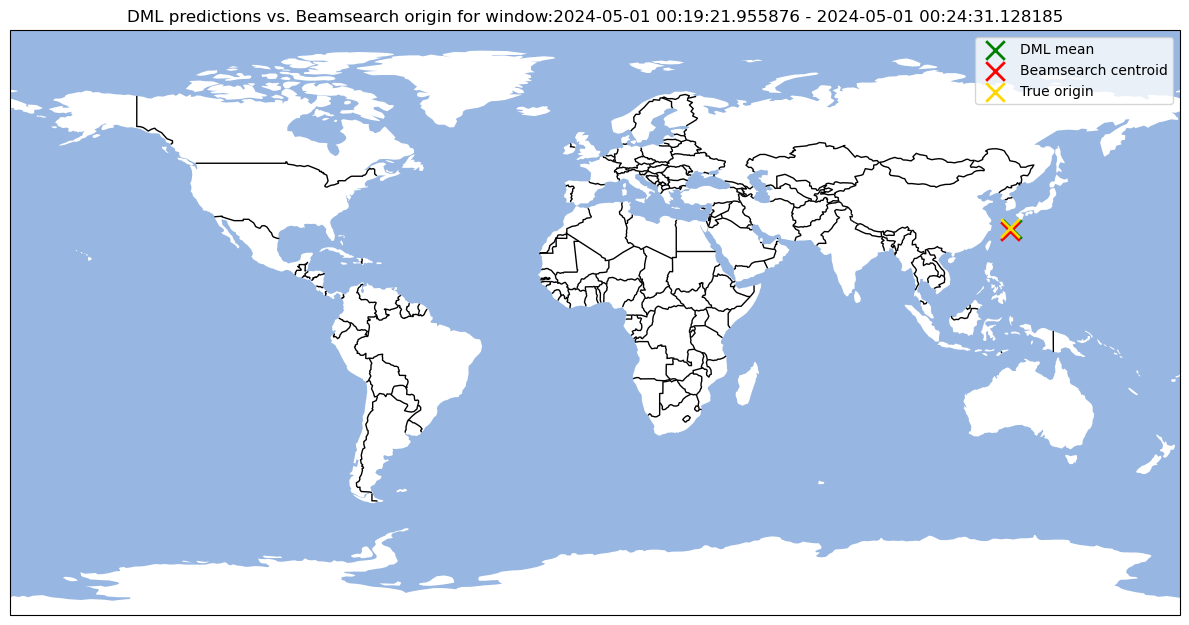

True origin time: 2024-05-01 00:12:42.541092
Beam origin time: 127.5867858609917
origin lat:     29.0815805999
dml_mean  lat:  28.844647248175
beamsearch lat: 28.081318808525335
origin lon:     127.6028955088
dml_mean  lon:  128.19165821553125
beamsearch lon: 127.5867858609917


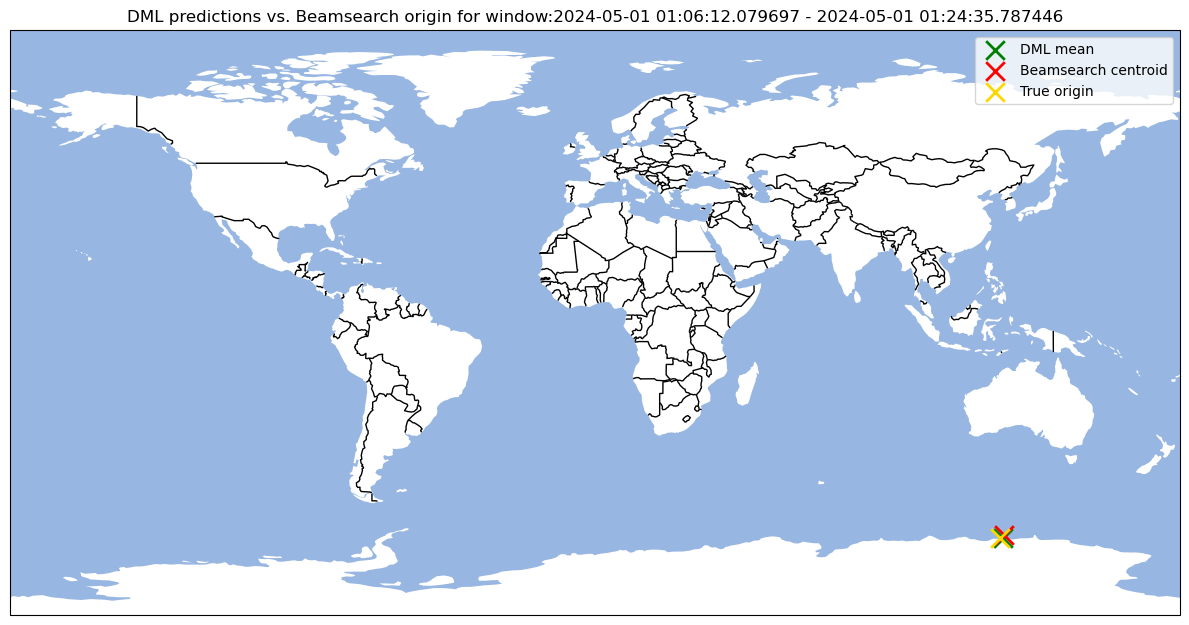

True origin time: 2024-05-01 01:01:34.522710
Beam origin time: 125.811781591603
origin lat:     -66.4389088805
dml_mean  lat:  -66.3459777598125
beamsearch lat: -65.33628074551581
origin lon:     124.7422410975
dml_mean  lon:  125.62061944435
beamsearch lon: 125.811781591603


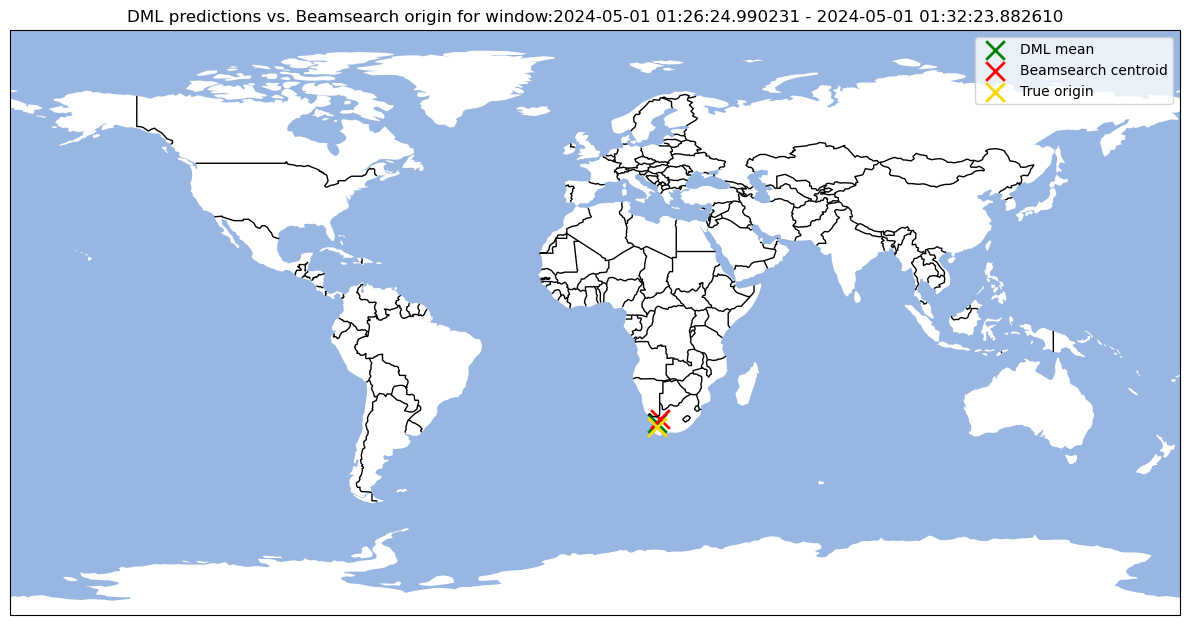

True origin time: 2024-05-01 01:19:59.696761
Beam origin time: 20.00367376420218
origin lat:     -32.0434908357
dml_mean  lat:  -30.817402642183332
beamsearch lat: -29.54121829405867
origin lon:     19.1726441268
dml_mean  lon:  18.977059532283334
beamsearch lon: 20.00367376420218
origin lat:     -32.0434908357
dml_mean  lat:  -30.817402642183332
beamsearch lat: -29.54121829405867
origin lon:     19.1726441268
dml_mean  lon:  18.977059532283334
beamsearch lon: 20.00367376420218


In [15]:
import matplotlib.pyplot as plt
from statistics import mean
import cartopy

plt.rcParams['figure.figsize'] = [12,12]

try:
    for i in range(len(bulletin.ORIG_TIME.unique())):

        origin_time = bulletin.ORIG_TIME.unique()[i]
        origin_lon = bulletin.ORIG_LON.unique()[i]
        origin_lat = bulletin.ORIG_LAT.unique()[i]

        dml_lat_mean = origins.DML_mean_lat.iloc[i]
        dml_lon_mean = origins.DML_mean_lon.iloc[i]
        beamsearch_lat = origins.Beamsearch_lat.iloc[i]    
        beamsearch_lon = origins.Beamsearch_lon.iloc[i]
        beamsearch_time = origins.Beamsearch_lon.iloc[i]

        geo_axes = plt.axes(projection=cartopy.crs.PlateCarree())
        geo_axes.add_feature(cartopy.feature.BORDERS)
        geo_axes.add_feature(cartopy.feature.OCEAN)
        geo_axes.scatter(dml_lon_mean, dml_lat_mean, marker='x', linewidth=2, c='g', s=180, alpha=1, label="DML mean")
        geo_axes.scatter(beamsearch_lon, beamsearch_lat, marker='x', linewidth=2, c='r', s=180, alpha=1, label="Beamsearch centroid")
        geo_axes.scatter(origin_lon, origin_lat, marker='x', linewidth=2, c='gold', s=180, alpha=1, label="True origin")
        geo_axes.set_global()
        
        plt.title("DML predictions vs. Beamsearch origin for window:" + str(origins.Window_start.iloc[i]) + " - " + str(origins.Window_end.iloc[i]))
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print("True origin time:", origin_time)
        print("Beam origin time:", beamsearch_time)
        
        print("origin lat:    ", origin_lat)
        print("dml_mean  lat: ", dml_lat_mean)
        print("beamsearch lat:", beamsearch_lat)

        print("origin lon:    ", origin_lon)
        print("dml_mean  lon: ", dml_lon_mean)
        print("beamsearch lon:", beamsearch_lon)

        
        
except Exception as e:
    print(e)
    


print("origin lat:    ", origin_lat)
print("dml_mean  lat: ", dml_lat_mean)
print("beamsearch lat:", beamsearch_lat)

print("origin lon:    ", origin_lon)
print("dml_mean  lon: ", dml_lon_mean)
print("beamsearch lon:", beamsearch_lon)